# 5-1,数据管道Dataset

如果需要训练的数据大小不大，例如不到1G，那么可以直接全部读入内存中进行训练，这样一般效率最高。

但如果需要训练的数据很大，例如超过10G，无法一次载入内存，那么通常需要在训练的过程中分批逐渐读入。

使用 tf.data API 可以构建数据输入管道，轻松处理大量的数据，不同的数据格式，以及不同的数据转换。

### 一，构建数据管道

可以从 Numpy array, Pandas DataFrame, Python generator, csv文件, 文本文件, 文件路径, tfrecords文件等方式构建数据管道。

其中通过Numpy array, Pandas DataFrame, 文件路径构建数据管道是最常用的方法。

通过tfrecords文件方式构建数据管道较为复杂，需要对样本构建tf.Example后压缩成字符串写到tfrecoreds文件，读取后再解析成tf.Example。

但tfrecoreds文件的优点是压缩后文件较小，便于网络传播，加载速度较快。

**1,从Numpy array构建数据管道**

In [1]:
# 从Numpy array构建数据管道

import tensorflow as tf
import numpy as np 
from sklearn import datasets 
iris = datasets.load_iris()


ds1 = tf.data.Dataset.from_tensor_slices((iris["data"],iris["target"]))
for features,label in ds1.take(5):
    print(features,label)


tf.Tensor([5.1 3.5 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.9 3.  1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.7 3.2 1.3 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.6 3.1 1.5 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([5.  3.6 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)


**2,从 Pandas DataFrame构建数据管道**

In [ ]:
# 从 Pandas DataFrame构建数据管道
import tensorflow as tf
from sklearn import datasets 
import pandas as pd
iris = datasets.load_iris()
dfiris = pd.DataFrame(iris["data"],columns = iris.feature_names)
ds2 = tf.data.Dataset.from_tensor_slices((dfiris.to_dict("list"),iris["target"]))

for features,label in ds2.take(3):
    print(features,label)

```
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=5.1>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.5>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=4.9>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=4.7>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.2>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.3>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
```

**3,从Python generator构建数据管道**

In [2]:
# 从Python generator构建数据管道
import tensorflow as tf
from matplotlib import pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 定义一个从文件中读取图片的generator
image_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
                    "./data/cifar2/test/",
                    target_size=(32, 32),
                    batch_size=20,
                    class_mode='binary')

classdict = image_generator.class_indices
print(classdict)

def generator():
    for features,label in image_generator:
        yield (features,label)

ds3 = tf.data.Dataset.from_generator(generator,output_types=(tf.float32,tf.int32))

Found 2000 images belonging to 2 classes.
{'airplane': 0, 'automobile': 1}


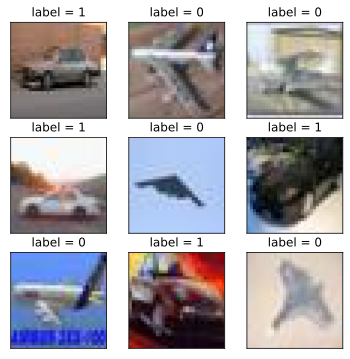

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,6)) 
for i,(img,label) in enumerate(ds3.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

**4,从csv文件构建数据管道**

In [ ]:
# 从csv文件构建数据管道
ds4 = tf.data.experimental.make_csv_dataset(
      file_pattern = ["./data/titanic/train.csv","./data/titanic/test.csv"],
      batch_size=3, 
      label_name="Survived",
      na_value="",
      num_epochs=1,
      ignore_errors=True)

for data,label in ds4.take(2):
    print(data,label)

```
OrderedDict([('PassengerId', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([540,  58, 764], dtype=int32)>), ('Pclass', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 3, 1], dtype=int32)>), ('Name', <tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Frolicher, Miss. Hedwig Margaritha', b'Novel, Mr. Mansouer',
       b'Carter, Mrs. William Ernest (Lucile Polk)'], dtype=object)>), ('Sex', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'female', b'male', b'female'], dtype=object)>), ('Age', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([22. , 28.5, 36. ], dtype=float32)>), ('SibSp', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 1], dtype=int32)>), ('Parch', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 0, 2], dtype=int32)>), ('Ticket', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'13568', b'2697', b'113760'], dtype=object)>), ('Fare', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 49.5   ,   7.2292, 120.    ], dtype=float32)>), ('Cabin', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'B39', b'', b'B96 B98'], dtype=object)>), ('Embarked', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'C', b'C', b'S'], dtype=object)>)]) tf.Tensor([1 0 1], shape=(3,), dtype=int32)
OrderedDict([('PassengerId', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([845,  66, 390], dtype=int32)>), ('Pclass', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 3, 2], dtype=int32)>), ('Name', <tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Culumovic, Mr. Jeso', b'Moubarek, Master. Gerios',
       b'Lehmann, Miss. Bertha'], dtype=object)>), ('Sex', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'male', b'male', b'female'], dtype=object)>), ('Age', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([17.,  0., 17.], dtype=float32)>), ('SibSp', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 1, 0], dtype=int32)>), ('Parch', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 1, 0], dtype=int32)>), ('Ticket', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'315090', b'2661', b'SC 1748'], dtype=object)>), ('Fare', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 8.6625, 15.2458, 12.    ], dtype=float32)>), ('Cabin', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'', b'', b''], dtype=object)>), ('Embarked', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'S', b'C', b'C'], dtype=object)>)]) tf.Tensor([0 1 1], shape=(3,), dtype=int32)
```

**5,从文本文件构建数据管道**

In [ ]:
# 从文本文件构建数据管道

ds5 = tf.data.TextLineDataset(
    filenames = ["./data/titanic/train.csv","./data/titanic/test.csv"]
    ).skip(1) #略去第一行header

for line in ds5.take(5):
    print(line)

```
tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
tf.Tensor(b'388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,,S', shape=(), dtype=string)
```

**6,从文件路径构建数据管道**

In [4]:
ds6 = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg")
for file in ds6.take(5):
    print(file)

tf.Tensor(b'./data/cifar2/train/automobile/1086.jpg', shape=(), dtype=string)
tf.Tensor(b'./data/cifar2/train/automobile/3856.jpg', shape=(), dtype=string)
tf.Tensor(b'./data/cifar2/train/automobile/2784.jpg', shape=(), dtype=string)
tf.Tensor(b'./data/cifar2/train/airplane/434.jpg', shape=(), dtype=string)
tf.Tensor(b'./data/cifar2/train/airplane/1494.jpg', shape=(), dtype=string)


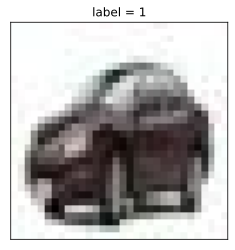

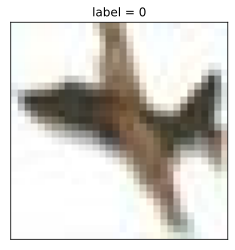

In [5]:
from matplotlib import pyplot as plt 
def load_image(img_path,size = (32,32)):
    label = 1 if tf.strings.regex_full_match(img_path,".*/automobile/.*") else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)
    return(img,label)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
for i,(img,label) in enumerate(ds6.map(load_image).take(2)):
    plt.figure(i)
    plt.imshow((img/255.0).numpy())
    plt.title("label = %d"%label)
    plt.xticks([])
    plt.yticks([])

![](./data/5-1-car2.jpg)

**7,从tfrecords文件构建数据管道**

In [ ]:
import os
import numpy as np

# inpath：原始数据路径 outpath:TFRecord文件输出路径
def create_tfrecords(inpath,outpath): 
    writer = tf.io.TFRecordWriter(outpath)
    dirs = os.listdir(inpath)
    for index, name in enumerate(dirs):
        class_path = inpath +"/"+ name+"/"
        for img_name in os.listdir(class_path):
            img_path = class_path + img_name
            img = tf.io.read_file(img_path)
            #img = tf.image.decode_image(img)
            #img = tf.image.encode_jpeg(img) #统一成jpeg格式压缩
            example = tf.train.Example(
               features=tf.train.Features(feature={
                    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[index])),
                    'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img.numpy()]))
               }))
            writer.write(example.SerializeToString())
    writer.close()
    
create_tfrecords("./data/cifar2/test/","./data/cifar2_test.tfrecords/")


In [ ]:
from matplotlib import pyplot as plt 

def parse_example(proto):
    description ={ 'img_raw' : tf.io.FixedLenFeature([], tf.string),
                   'label': tf.io.FixedLenFeature([], tf.int64)} 
    example = tf.io.parse_single_example(proto, description)
    img = tf.image.decode_jpeg(example["img_raw"])   #注意此处为jpeg格式
    img = tf.image.resize(img, (32,32))
    label = example["label"]
    return(img,label)

ds7 = tf.data.TFRecordDataset("./data/cifar2_test.tfrecords").map(parse_example).shuffle(3000)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,6)) 
for i,(img,label) in enumerate(ds7.take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow((img/255.0).numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()


![](./data/5-1-car9.jpg)

### 二，应用数据转换

Dataset数据结构应用非常灵活，因为它本质上是一个Sequece序列，其每个元素可以是各种类型，例如可以是张量，列表，字典，也可以是Dataset。

Dataset包含了非常丰富的数据转换功能。

* map: 将转换函数映射到数据集每一个元素。

* flat_map: 将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平。

* interleave: 效果类似flat_map,但可以将不同来源的数据夹在一起。

* filter: 过滤掉某些元素。

* zip: 将两个长度相同的Dataset横向铰合。

* concatenate: 将两个Dataset纵向连接。

* reduce: 执行归并操作。

* batch : 构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。

* padded_batch: 构建批次，类似batch, 但可以填充到相同的形状。

* window :构建滑动窗口，返回Dataset of Dataset.

* shuffle: 数据顺序洗牌。

* repeat: 重复数据若干次，不带参数时，重复无数次。

* shard: 采样，从某个位置开始隔固定距离采样一个元素。

* take: 采样，从开始位置取前几个元素。


In [ ]:
#map:将转换函数映射到数据集每一个元素

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_map = ds.map(lambda x:tf.strings.split(x," "))
for x in ds_map:
    print(x)

```
tf.Tensor([b'hello' b'world'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'China'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'Beijing'], shape=(2,), dtype=string)
```

In [ ]:
#flat_map:将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_flatmap = ds.flat_map(lambda x:tf.data.Dataset.from_tensor_slices(tf.strings.split(x," ")))
for x in ds_flatmap:
    print(x)

```
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'China', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)
```

In [ ]:
# interleave: 效果类似flat_map,但可以将不同来源的数据夹在一起。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_interleave = ds.interleave(lambda x:tf.data.Dataset.from_tensor_slices(tf.strings.split(x," ")))
for x in ds_interleave:
    print(x)
    

```
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'China', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)
```

In [ ]:
#filter:过滤掉某些元素。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
#找出含有字母a或B的元素
ds_filter = ds.filter(lambda x: tf.strings.regex_full_match(x, ".*[a|B].*"))
for x in ds_filter:
    print(x)
    

```
tf.Tensor(b'hello China', shape=(), dtype=string)
tf.Tensor(b'hello Beijing', shape=(), dtype=string)
```

In [ ]:
#zip:将两个长度相同的Dataset横向铰合。

ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds3 = tf.data.Dataset.range(6,9)
ds_zip = tf.data.Dataset.zip((ds1,ds2,ds3))
for x,y,z in ds_zip:
    print(x.numpy(),y.numpy(),z.numpy())


```
0 3 6
1 4 7
2 5 8
```

In [ ]:
#condatenate:将两个Dataset纵向连接。

ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds_concat = tf.data.Dataset.concatenate(ds1,ds2)
for x in ds_concat:
    print(x)

```
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
```

In [ ]:
#reduce:执行归并操作。

ds = tf.data.Dataset.from_tensor_slices([1,2,3,4,5.0])
result = ds.reduce(0.0,lambda x,y:tf.add(x,y))
result

```
<tf.Tensor: shape=(), dtype=float32, numpy=15.0>
```

In [ ]:
#batch:构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。 

ds = tf.data.Dataset.range(12)
ds_batch = ds.batch(4)
for x in ds_batch:
    print(x)

```
tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int64)
tf.Tensor([ 8  9 10 11], shape=(4,), dtype=int64)
```

In [ ]:
#padded_batch:构建批次，类似batch, 但可以填充到相同的形状。

elements = [[1, 2],[3, 4, 5],[6, 7],[8]]
ds = tf.data.Dataset.from_generator(lambda: iter(elements), tf.int32)

ds_padded_batch = ds.padded_batch(2,padded_shapes = [4,])
for x in ds_padded_batch:
    print(x)    

```
tf.Tensor(
[[1 2 0 0]
 [3 4 5 0]], shape=(2, 4), dtype=int32)
tf.Tensor(
[[6 7 0 0]
 [8 0 0 0]], shape=(2, 4), dtype=int32)
```

In [ ]:
#window:构建滑动窗口，返回Dataset of Dataset.

ds = tf.data.Dataset.range(12)
#window返回的是Dataset of Dataset,可以用flat_map压平
ds_window = ds.window(3, shift=1).flat_map(lambda x: x.batch(3,drop_remainder=True)) 
for x in ds_window:
    print(x)

```
tf.Tensor([0 1 2], shape=(3,), dtype=int64)
tf.Tensor([1 2 3], shape=(3,), dtype=int64)
tf.Tensor([2 3 4], shape=(3,), dtype=int64)
tf.Tensor([3 4 5], shape=(3,), dtype=int64)
tf.Tensor([4 5 6], shape=(3,), dtype=int64)
tf.Tensor([5 6 7], shape=(3,), dtype=int64)
tf.Tensor([6 7 8], shape=(3,), dtype=int64)
tf.Tensor([7 8 9], shape=(3,), dtype=int64)
tf.Tensor([ 8  9 10], shape=(3,), dtype=int64)
tf.Tensor([ 9 10 11], shape=(3,), dtype=int64)
```

In [ ]:
#shuffle:数据顺序洗牌。

ds = tf.data.Dataset.range(12)
ds_shuffle = ds.shuffle(buffer_size = 5)
for x in ds_shuffle:
    print(x)
    

```
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(11, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
```

In [ ]:
#repeat:重复数据若干次，不带参数时，重复无数次。

ds = tf.data.Dataset.range(3)
ds_repeat = ds.repeat(3)
for x in ds_repeat:
    print(x)

```
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
```

In [ ]:
#shard:采样，从某个位置开始隔固定距离采样一个元素。

ds = tf.data.Dataset.range(12)
ds_shard = ds.shard(3,index = 1)

for x in ds_shard:
    print(x)

```
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
```

In [ ]:
#take:采样，从开始位置取前几个元素。

ds = tf.data.Dataset.range(12)
ds_take = ds.take(3)

list(ds_take.as_numpy_iterator())


```
[0, 1, 2]
```

### 三，提升管道性能

训练深度学习模型常常会非常耗时。

模型训练的耗时主要来自于两个部分，一部分来自**数据准备**，另一部分来自**参数迭代**。

参数迭代过程的耗时通常依赖于GPU来提升。

而数据准备过程的耗时则可以通过构建高效的数据管道进行提升。

以下是一些构建高效数据管道的建议。

* 1，使用 prefetch 方法让数据准备和参数迭代两个过程相互并行。

* 2，使用 interleave 方法可以让数据读取过程多进程执行,并将不同来源数据夹在一起。

* 3，使用 map 时设置num_parallel_calls 让数据转换过程多进行执行。

* 4，使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。

* 5，使用 map转换时，先batch, 然后采用向量化的转换方法对每个batch进行转换。

**1，使用 prefetch 方法让数据准备和参数迭代两个过程相互并行。**

In [6]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    ts = tf.timestamp()
    today_ts = ts%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8,end = "")
    tf.print(timestring)
    

In [7]:
import time

# 数据准备和参数迭代两个过程默认情况下是串行的。

# 模拟数据准备
def generator():
    for i in range(10):
        #假设每次准备数据需要2s
        time.sleep(2) 
        yield i 
ds = tf.data.Dataset.from_generator(generator,output_types = (tf.int32))

# 模拟参数迭代
def train_step():
    #假设每一步训练需要1s
    time.sleep(1) 
    

In [8]:
# 训练过程预计耗时 10*2+10*1+ = 30s
printbar()
tf.print(tf.constant("start training..."))
for x in ds:
    train_step()  
printbar()
tf.print(tf.constant("end training..."))

================================================================================14:54:23
start training...
================================================================================14:54:53
end training...


In [9]:
# 使用 prefetch 方法让数据准备和参数迭代两个过程相互并行。

# 训练过程预计耗时 max(10*2,10*1) = 20s
printbar()
tf.print(tf.constant("start training with prefetch..."))

# tf.data.experimental.AUTOTUNE 可以让程序自动选择合适的参数
for x in ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE):
    train_step()  
    
printbar()
tf.print(tf.constant("end training..."))


================================================================================14:54:59
start training with prefetch...
================================================================================14:55:20
end training...


**2，使用 interleave 方法可以让数据读取过程多进程执行,并将不同来源数据夹在一起。**

In [10]:
ds_files = tf.data.Dataset.list_files("./data/titanic/*.csv")
ds = ds_files.flat_map(lambda x:tf.data.TextLineDataset(x).skip(1))
for line in ds.take(4):
    print(line)

tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
tf.Tensor(b'388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0,,S', shape=(), dtype=string)


In [11]:
ds_files = tf.data.Dataset.list_files("./data/titanic/*.csv")
ds = ds_files.interleave(lambda x:tf.data.TextLineDataset(x).skip(1))
for line in ds.take(8):
    print(line)

tf.Tensor(b'181,0,3,"Sage, Miss. Constance Gladys",female,,8,2,CA. 2343,69.55,,S', shape=(), dtype=string)
tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'405,0,3,"Oreskovic, Miss. Marija",female,20.0,0,0,315096,8.6625,,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
tf.Tensor(b'635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9,,S', shape=(), dtype=string)
tf.Tensor(b'388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,PC 17757,227.525,C62 C64,C', shape=(), dtype=string)
tf.Tensor(b'192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0,,S', shape=(), dtype=string)


**3，使用 map 时设置num_parallel_calls 让数据转换过程多进行执行。**

In [12]:
ds = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg")
def load_image(img_path,size = (32,32)):
    label = 1 if tf.strings.regex_full_match(img_path,".*/automobile/.*") else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)
    return(img,label)

In [13]:
#单进程转换
printbar()
tf.print(tf.constant("start transformation..."))

ds_map = ds.map(load_image)
for _ in ds_map:
    pass

printbar()
tf.print(tf.constant("end transformation..."))

================================================================================14:56:11
start transformation...
================================================================================14:56:24
end transformation...


In [14]:
#多进程转换
printbar()
tf.print(tf.constant("start parallel transformation..."))

ds_map_parallel = ds.map(load_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
for _ in ds_map_parallel:
    pass

printbar()
tf.print(tf.constant("end parallel transformation..."))

================================================================================14:56:27
start parallel transformation...
================================================================================14:56:34
end parallel transformation...


**4，使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。**

In [15]:
import time

# 模拟数据准备
def generator():
    for i in range(5):
        #假设每次准备数据需要2s
        time.sleep(2) 
        yield i 
ds = tf.data.Dataset.from_generator(generator,output_types = (tf.int32))

# 模拟参数迭代
def train_step():
    #假设每一步训练需要0s
    pass

# 训练过程预计耗时 (5*2+5*0)*3 = 30s
printbar()
tf.print(tf.constant("start training..."))
for epoch in tf.range(3):
    for x in ds:
        train_step()  
    printbar()
    tf.print("epoch =",epoch," ended")
printbar()
tf.print(tf.constant("end training..."))


================================================================================14:56:49
start training...
================================================================================14:56:59
epoch = 0  ended
================================================================================14:57:09
epoch = 1  ended
================================================================================14:57:19
epoch = 2  ended
================================================================================14:57:19
end training...


In [16]:
import time

# 模拟数据准备
def generator():
    for i in range(5):
        #假设每次准备数据需要2s
        time.sleep(2) 
        yield i 

# 使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。
ds = tf.data.Dataset.from_generator(generator,output_types = (tf.int32)).cache()

# 模拟参数迭代
def train_step():
    #假设每一步训练需要0s
    time.sleep(0) 

# 训练过程预计耗时 (5*2+5*0)+(5*0+5*0)*2 = 10s
printbar()
tf.print(tf.constant("start training..."))
for epoch in tf.range(3):
    for x in ds:
        train_step()  
    printbar()
    tf.print("epoch =",epoch," ended")
printbar()
tf.print(tf.constant("end training..."))

================================================================================14:57:19
start training...
================================================================================14:57:29
epoch = 0  ended
================================================================================14:57:29
epoch = 1  ended
================================================================================14:57:29
epoch = 2  ended
================================================================================14:57:29
end training...


**5，使用 map转换时，先batch, 然后采用向量化的转换方法对每个batch进行转换。**

In [17]:
#先map后batch
ds = tf.data.Dataset.range(100000)
ds_map_batch = ds.map(lambda x:x**2).batch(20)

printbar()
tf.print(tf.constant("start scalar transformation..."))
for x in ds_map_batch:
    pass
printbar()
tf.print(tf.constant("end scalar transformation..."))


================================================================================14:57:46
start scalar transformation...
================================================================================14:58:06
end scalar transformation...


In [18]:
#先batch后map
ds = tf.data.Dataset.range(100000)
ds_batch_map = ds.batch(20).map(lambda x:x**2)

printbar()
tf.print(tf.constant("start vector transformation..."))
for x in ds_batch_map:
    pass
printbar()
tf.print(tf.constant("end vector transformation..."))


================================================================================14:58:06
start vector transformation...
================================================================================14:58:08
end vector transformation...
